Uvoz potrebnih knižnic

In [2]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os # da lahko dostopa do datotek na računalniku
import math
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

Naložimo še model VGG16, ki ga bomo  kasneje potrebovali. To lahko traja nekaj časa, ker je model obsežen. 

In [3]:
# Naloži VGG16 brez top plasti
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

2025-11-18 19:04:38.229388: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 1. Konvolucijska nevronska mreža za prepoznavanje ročno napisanih števk

Najprej bomo ročno ustvarili konvolucijsko nevronsko mrežo za prepoznavanje števk. Uporabili bomo Kerasovo knjižnico MNIST.

## 1.1 Uvoz podatkov

Knjižnica MNIST vsebuje slike ročno napisanih števk od 0 do 9. Slike so velikosti 28×28 in so v sivi skali. Podatki so že razdeljeni na train (učni) in test (preizkusni) niz, zato jih uvozimo ločeno.
Ogledali si še bomo, kako podatki izgledajo v "surovi" obliki kot 28×28 matriko in tudi kot sliko. Na koncu še izpišemo število slik v učnem in preizkusnem nizu.


Slika v matrični obliki:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 2

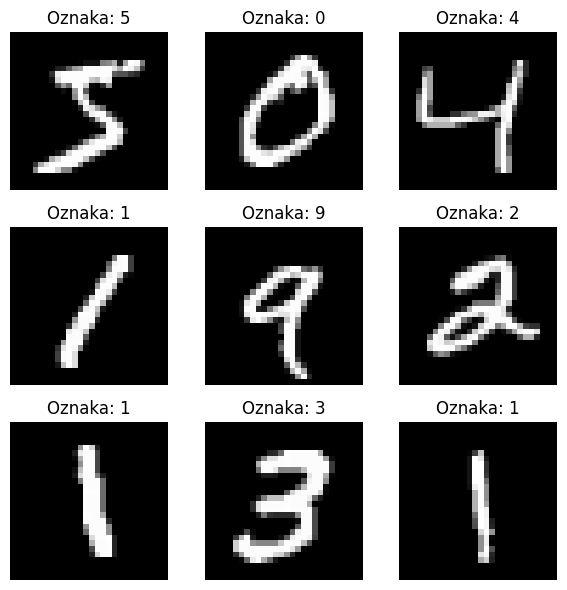

Niz x_train vsebuje 60000 slik
Niz x_test vsebuje 10000 slik


In [4]:
# Uvoz podatkov iz knjižnice. Listi x_train in x_test vsebujejo slike, listi y_train in y_test pa njihove oznake 
#(katera števka je prikazana)
from tensorflow.keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

# Dajmo pogledati kako izgledajo podatki v "surovi" obliki
print("Slika v matrični obliki:")    
print(x_train[0])
print()
print(f"Oznaka: {y_train[0]}")

# narišimo prvih 9 slik in na njimi zapišimo oznako
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Oznaka: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Izpišimo še število slik v obeh podatkovih nizih (ukaz len(niz) prešteje elemente v nizu)
print(f"Niz x_train vsebuje {len(x_train)} slik")
print(f"Niz x_test vsebuje {len(x_test)} slik")

Vidimo torej, da baza vsebuje 70.000 slik, razdeljenih v dve skupini: 60.000 slik za učenje modela in 10.000 slik za preverjanje / testiranje modela. Slike so črno-bele, pri čemer prikazujejo belo številko na črnem ozadju. V matrični obliki so barve oziroma sivine predstavljene s številkami od 0 do 255, pri čemer 0 pomeni črno, 255 pa belo.

## 1.2 Priprava podatkov

Naslednji korak je priprava podatkov. To bomo storili v naslednjih korakih:

1. **Pretvorba v Kerasov podatkovni tip Dataset**: Čeprav Keras podpira tudi numpy arraye, bomo v tem primeru vhodne podatke pretvoriti v poseben tip spremenljivke (Dataset). Vsak vhod v tej obliki je sestavljen iz testiranca (slike) in oznake (kaj je na sliki).

2. **Normalizacija**: Nevronske mreže raje obravnavajo decimalna števila med 0 in 1 ali med -1 in 1, zato bo model bolje deloval, če vrednosti slik normaliziramo. To pomeni, da bomo namesto ozak za sivino v obliki celih števil od 0 do 255 uporabili decimalna števila med 0 in 1. Definiramo posebno funkcijo "normaliziraj", ki najprej številke v matrikah pretvori iz celih števil (integer) v realna števila (float) z ukazom tf.cast. Nato slike delimo z 255.0, da dobimo vrednosti med 0 in 1.

3. **Pakiranje**: Na koncu slike še spakiramo v pakete, ki jih pošiljamo kot trening podatke. Najprej z ukazom .map(normaliziraj) normaliziramo slike, nato pa jih z ukazom .batch(32) spakiramo v pakete po 32, ki jih model obravnava "skupaj" preden prilagodi uteži. Z ukazom .prefetch še računalniku naročimo, da naloži naslednji paket preden konča trening na prejšnjem – s tem nekoliko pohitrimo postopek, če imamo dovolj jeder.

Na koncu še z ukazom .take(1) vzamemo prvi paket iz niza – ta vsebuje 32 slik, zloženih v nizu – in izpišemo, kako zdaj izgleda prva (normalizirana) slika. 

In [5]:

# 2) Pretvorimo podatke in numpy arraya v tf.data.Dataset, ki ga Keras lažje razume. Naredmo ločeno za 
# train in test podatke.
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 3) Normalizacija funkcija
def normaliziraj(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 4) Uporaba normalizacije in priprava batchov
ds_train = ds_train.map(normaliziraj).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(normaliziraj).batch(32).prefetch(tf.data.AUTOTUNE)

# vzemi en batch iz ds_train
for images, labels in ds_train.take(1):
    first_image = images[0]
    first_label = labels[0]
    break

# nariši
print(first_image.numpy())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

## 1.3 Priprava modela

Sledi gradnja in treniranje modela po že uhojenih korakih:

1. ***Gradnja arhitekture:*** Sestavimo konvolucijsko mrežo z naslednjimi elementi:

    a) Najprej konvolucijska plast z 32 vozlišči in jedrom velikosti 3×3 z aktivacijo ReLU. Tukaj tudi zapišemo, kakšne oblike vhoda naj mreža pričakuje. V našem primeru je to ***(28,28,1)***, kar pomeni, da gre za 28×28 pikslov veliko sliko, ki je črno-bela ***(zadnja 1-ka označuje črno-belo različico)***. Barvne slike enake velikosti bi bile (28,28,3), saj potrebujemo tri (RGB) kanale, da določimo barvo.
    b) Sledi MaxPooling plast z jedrom 2×2.
    c) Ponovno konvolucijska plast, tokrat z 64 vozlišči, ostalo enako.
    d) Ponovno MaxPooling plast.
    e) Uporabimo Flatten plast, da podatke spremenimo v 1D vektor.
    f) Sledijo še dve gosti (Dense) plasti, pri čemer ima zadnja plast 10 vozlišč, ker imamo 10 števk (0–9).

2. ***Priprava modela:*** Za stroškovno funkcijo uporabimo sparse_categorical_crossentropy, optimizator je Adam, metrika pa accuracy – to so klasične in preverjene izbire za klasifikacijo MNIST slik.

3. ***Treniranje modela:*** Kot vhod uporabimo ds_train za trening in ds_test za validacijo modela. Uporabili bomo 5 epoh, kar pomeni, da bo model petkrat prešel skozi celoten nabor podatkov.

4. ***Prikaz natančnosti (accuracy):*** Na koncu izrišemo graf natančnosti modela. Vidimo, da na trening sklopu dosegamo nekoliko boljše rezultate kot na validacijskem sklopu, kar pomeni, da se pojavlja rahli overfitting.

/home/anita/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9054 - loss: 0.3269 - val_accuracy: 0.9780 - val_loss: 0.0677
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9833 - loss: 0.0556 - val_accuracy: 0.9884 - val_loss: 0.0359
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9891 - loss: 0.0357 - val_accuracy: 0.9892 - val_loss: 0.0325
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9928 - loss: 0.0244 - val_accuracy: 0.9895 - val_loss: 0.0354
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9946 - loss: 0.0175 - val_accuracy: 0.9898 - val_loss: 0.0326


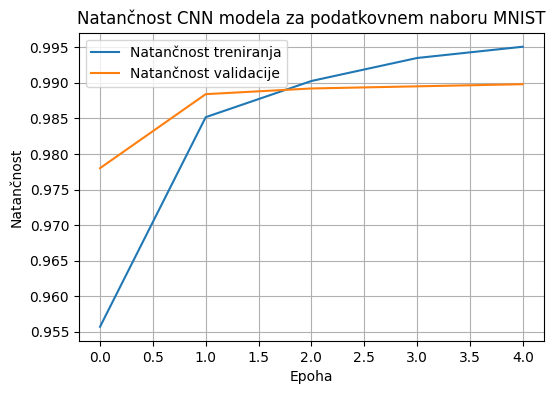

In [6]:

#  ---- Arhitektura ----

model_mnist = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_mnist.summary()

# -------- Priprava ----------
model_mnist.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -------- Učenje modela ----------
zgodovina = model_mnist.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)

# --------- Izris grafa natančnosti---------

plt.figure(figsize=(6,4))
plt.plot(zgodovina.history['accuracy'], label='Natančnost treniranja')
plt.plot(zgodovina.history['val_accuracy'], label='Natančnost validacije')
plt.xlabel('Epoha')
plt.ylabel('Natančnost')
plt.title('Natančnost CNN modela za podatkovnem naboru MNIST')
plt.legend()
plt.grid(True)
plt.show()

## 1.4 Uporaba modela

Sedaj, ko je model pripravljen in natreniran, je čas, da ga preverimo na realnih podatkih. Zato pripravimo nekaj posnetkov ročno napisanih številk. Najdete jih v Moodlu v mapi stevilke. Mapo prenesite v enak direktorij, kot se nahaja ta Jupyter dokument, ali pa ustrezno prilagodite pot, zapisano na začetku programa.

Čiste slike ne moremo neposredno poslati v nevronsko mrežo, ampak jih moramo najprej ustrezno preoblikovati:

 - Slike pretvorimo v format, ki ga TensorFlow razume (decode_png). Ker so slike črno-bele, nastavimo kanale na 1 (pri barvnih bi bil 3).

 - Številke, ki ponazarjajo sivino, pretvorimo v float vrednosti med 0 in 1 (normalizacija).

 - Ker so slike običajno temna pisava na belem papirju, jih je treba obrniti, tako da bo pisava bela na črnem ozadju. Model je namreč treniran na takšnih podatkih, zato bi sicer deloval slabše.

 - Model pričakuje slike velikosti 28×28, zato jih z ukazom resize prilagodimo tej velikosti.

 - Ker program pričakuje pakete (batch-e), dodamo še eno dimenzijo, da obliko vhoda prilagodimo temu, kar model pričakuje.

Nato slike preberemo in jih spustimo skozi model. Kot smo že navajeni, kot izhod ne dobimo neposredno kategorije, ampak vektor desetih števil, kjer vsaka vrednost predstavlja verjetnost, da slika pripada določeni kategoriji.
Z ukazom np.argmax() poiščemo element z največjo verjetnostjo. Ker gre za števke od 0 do 9, je indeks elementa z največjo verjetnostjo naša napoved.

Na koncu slike še narišemo: prikazujemo jih po 4 v vrsto, nad vsako sliko pa kot naslov napišemo napovedano vrednost.


Najdene slike: ['SL_6.png', 'SL_3.png', 'sl_6.png', 'SL_7.png', 'sl_5.png', 'sl_3.png', 'SL_1.png', 'sl_1.png', 'sl_4.png', 'SL_2.png', 'SL_4.png', 'sl_2.png']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


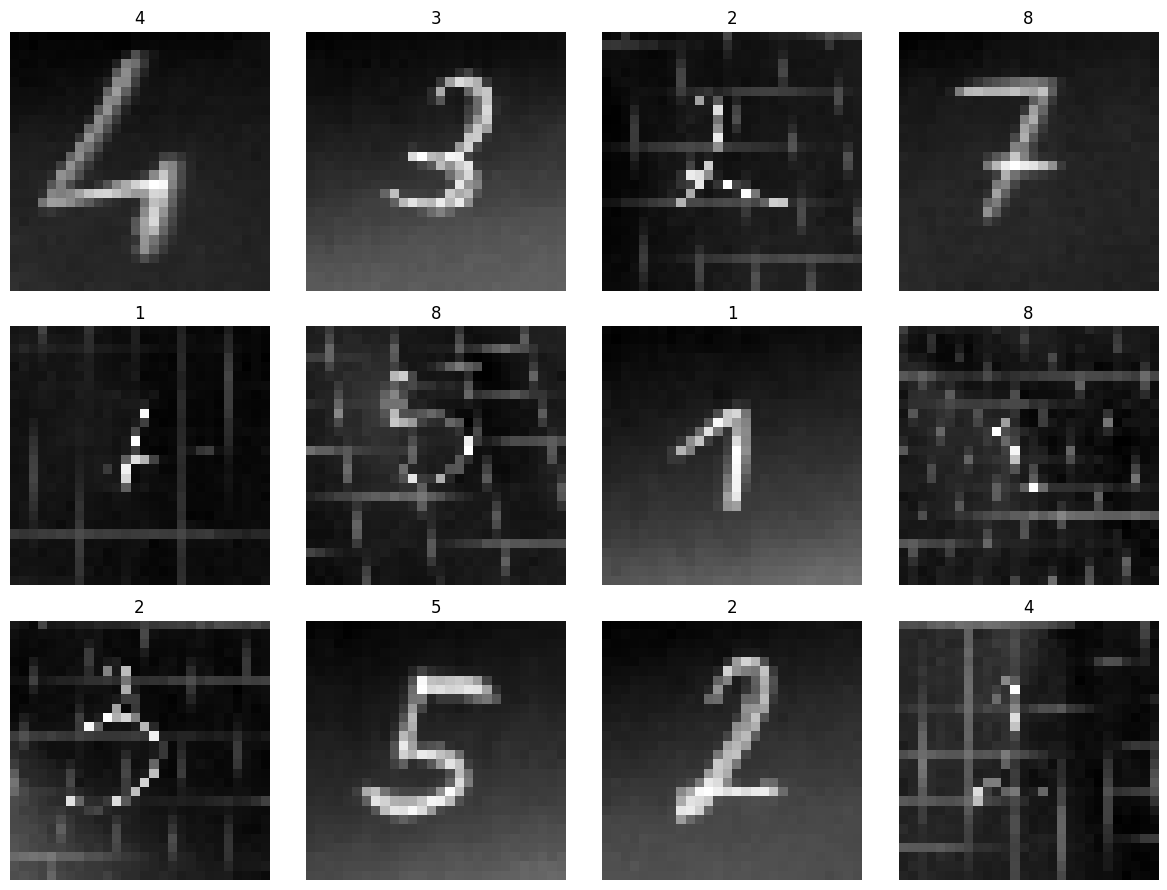

sl_2.png: napoved = [[0.07 0.18 0.04 0.02 0.23 0.13 0.08 0.08 0.07 0.09]]


In [7]:
# ------ Poiščemo mapo in preverimo katere slike so v njej ------------

# Definiramo naslov do mape s slikami
mapa = "stevilke/"   # <-- prilagodi pot
# Pripravimo seznam vseh slik v mapi in ga izpišemo
files = [f for f in os.listdir(mapa) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
print("Najdene slike:", files)

# ------------  Obdelava slike ___________________
def prepare_image(path):
   
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)   # grayscale

    # pretvori v float (0–1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # invertira barve
    img = 1.0 - img

    # spremeni obliko v 28x28
    img = tf.image.resize(img, (28, 28))

    # doda batch dimenzijo
    img = tf.expand_dims(img, 0)   # (1,28,28,1)

    return img

#    print(f"{fname}: napoved = {pred_label}")



# -------------- Predikcija modela, risanje slik in izpis odgovorov ---------------

ncols = 4 # določimo število slik v vrstici
nimages = len(files) # preštejemo koliko slik imamo
nrows = math.ceil(nimages / ncols) # izačunamo število vrstic - math.ceil zaokroži število navzgor.
# Torej(4.1)=5


plt.figure(figsize=(ncols*3, nrows*3))

for i, fname in enumerate(files):
    path = os.path.join(mapa, fname)
    img_batch = prepare_image(path)
    pred = model_mnist.predict(img_batch)
    pred_label = np.argmax(pred)

    
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(tf.squeeze(img_batch).numpy(), cmap='gray')
    plt.title(f"{pred_label}")
    plt.axis('off')

    
plt.tight_layout()
plt.show()

# Izpišimo še "čisto" napoved za zadnjo sliko, ki prikazuje verjetosti za vse kategorije
print(f"{fname}: napoved = {np.round(pred,2)}")

V zadnji vrstici je v celoti izpisan napoved modela v obliki verjetnosti za vsaki vnos poseboej. Kot vidimo, je model imel kar nekaj težav z ugotavljanjem pravilnega odgovora. Zmagala je 5-ta z 18% verjetnostjo pred 3-ko z 17% verjetnostjo in 1-ko z 16% verjentostjo. Pravilen rezultat (2-ka) je napovedana z 10% verjetnostjo.

## 2.1 Kaggle internetna stran in pridobivanje podatkovnega niza

***Navodila:***

 1. Obiščemo spletno stran https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition in prenesemo podatkovni niz kot ZIP datoteko (gumb za prenos je v zgornjem desnem kotu).

2. V mapi, kjer se nahaja naša Jupyter datoteka, ustvarimo mapo ***vozila***. Vanjo razširimo preneseno ZIP datoteko. Odprimo mapo Dataset ter štiri mape ( Bus, Car, motorcycle in Truck ) prenesimo neposredno v mapo vozila, nato pa mapo Dataset izbrišimo. Zdaj imamo naslednjo strukturo: 
 - vozila/Bus
 - vozila/Car
 - vozila/motorcycle
 - vozila/Truck
 
 Vsaka mapa predstavlja svojo kategorijo.

 
 
## 2.2  Priprava slik

Za pripravo slik bomo uporabili ***ImageDataGenerator***. Njegova uporaba je zelo preprosta in prikazana v spodnjem primeru. Program izpiše, koliko je vseh slik v vzorcu train in validation ter koliko kategorij vsebuje podatkovni niz. Program je sam po sebi zelo jasen; razložiti je potrebno le parameter ***class_mode***. Za class_mode imamo tri možnosti: ***'binary'***, ***'categorical'*** ali ***'sparse'***.

 1. Možnost ***'binary'*** uporabljamo, kadar imamo le dve kategoriji in ima izhodna plast dimenzijo 1. Njena vrednost je med 0 in 1 ter predstavlja verjetnost ene izmed obeh kategorij.

2. Možnost ***'categorical'*** uporabljamo, kadar imamo več kategorij, ki so zapisane v obliki one-hot vektorja. Kot stroškovno funkcijo uporabljamo 'categorical_crossentropy'.

3. Možnost ***'sparse'*** je poenostavljena oblika one-hot zapisa. Kot stroškovno funkcijo uporabljamo 'sparse_categorical_crossentropy'. Zadnja plast ima toliko izhodov, kolikor je kategorij, vsaki izhod pa predstavlja eno kategorijo in verjetnost, da slika pripada tej kategoriji. Takšen način smo uporabili v prejšnjem primeru in ga bomo uporabili tudi sedaj. 

In [8]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # slike normaliziramo, da so vrednosti barv označene s števili od 0 do 1
    validation_split=0.2,  # definiramo, da želimo da nam 20% vzorca zadrži za validacijo
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    'vozila', #naslov mape, v kateri so shranjene slike
    target_size=(224, 224), #definiramo velikost, na katero želimo, da nam prilagodi slike (resize)
    batch_size=16, #definiramo velikost paketa, ki ga model vidi "naenkrat" preden zamenja uteži
    class_mode='sparse', #definiramo obliko kategorij 
    subset='training' #gre za podatke za učenje
)

val_gen = datagen.flow_from_directory(
    'vozila',
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    subset='validation' #vse enako kot prej, le da gre za validacijske podatke
)

Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


## 2.3 Postavitev modela

Sedaj bomo postavili model, baziran na modelu VGG16. V prvem koraku model "zamrznemo" z uporabo ukaza layer.trainable = False, kar pomeni, da obstoječe uteži med treniranjem ne bodo spreminjane.

Nato modelu dodamo dodatne plasti, vendar nekoliko drugače, kot smo do sedaj navajeni.
Z ukazom x = vgg.output se navežemo na zadnjo plast VGG16 modela. Naslednjo plast dodamo tako:

x = layers.ImePlasti(parametri)(x)


To pomeni, da dodamo novo plast, ki se veže na prejšnjo. S takšnim načinom dodajanja lahko novo plast povežemo na poljubno plast in tako ustvarimo npr. različne veje nevronske mreže.

Pri zadnji plasti namesto x = ... uporabimo output = .... Na koncu model definiramo tako, da podamo prvo in zadnjo plast (inputs, outputs), vmesne plasti pa se avtomatično dodajo. Ostalo sledi enako kot prej.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/home/anita/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-11-18 19:06:29.866988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-11-18 19:06:29.925352: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 1/20 ━━━━━━━━━━━━━━━━━━━━ 1:06 4s/step - accuracy: 0.3125 - loss: 1.6468

2025-11-18 19:06:31.828946: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-11-18 19:06:31.886281: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 2/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3281 - loss: 1.6409 

2025-11-18 19:06:33.660398: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


12/20 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3741 - loss: 1.4183

/home/anita/myenv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.4224 - loss: 1.3149 - val_accuracy: 0.8500 - val_loss: 0.4557
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8021 - loss: 0.4698 - val_accuracy: 0.8625 - val_loss: 0.3271
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9209 - loss: 0.2724 - val_accuracy: 0.8875 - val_loss: 0.2711
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9367 - loss: 0.1744 - val_accuracy: 0.9000 - val_loss: 0.2548
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9702 - loss: 0.1523 - val_accuracy: 0.9000 - val_loss: 0.2550
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9760 - loss: 0.1304 - val_accuracy: 0.9125 - val_loss: 0.2204
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9951 - loss: 0.0621 - val_accuracy: 0.8750 - val_loss: 0.2477
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9710 - loss: 0.0846 - val_accuracy: 0.8875 - val_loss: 0.2169
Epo

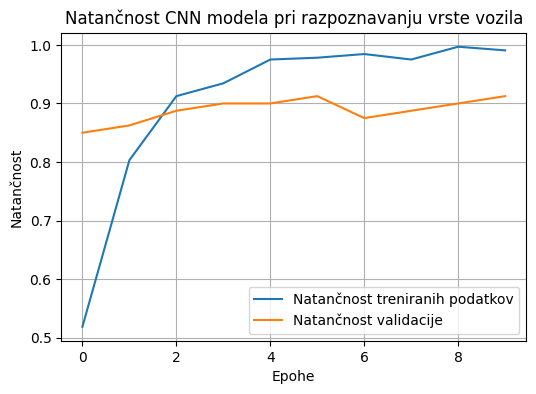

In [9]:

# Zamrzni vse plasti, da jih ne treniramo
for layer in vgg16.layers:
    layer.trainable = False

# Dodaj lastne Dense plasti
x = vgg16.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(4, activation='sigmoid')(x)  # binary klasifikacija

model_trafic = models.Model(inputs=vgg16.input, outputs=output)

model_trafic.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_trafic.summary()


history = model_trafic.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

# --------- Izris grafa natančnosti---------

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Natančnost treniranih podatkov')
plt.plot(history.history['val_accuracy'], label='Natančnost validacije')
plt.xlabel('Epohe')
plt.ylabel('Natančnost')
plt.title('Natančnost CNN modela pri razpoznavanju vrste vozila')
plt.legend()
plt.grid(True)
plt.show()

## 2.4  Preizkušanje modela

Na koncu še preizkusimo model na naših slikah. Želene slike prenesemo v novo mapo, ki se nahaja v istem direktoriju kot Jupyter datoteka, oziroma, če ni, ustrezno navedemo celotno pot do mape. V našem primeru bo to mapa "moja_vozila".

Slike iz direktorija preberemo na enak način, kot smo to storili prej. Nato jih normaliziramo in uporabimo model, da ugotovi, kaj je na njih. Program prav tako izpiše izračunane verjetnosti za vsako kategorijo ter izbrano (najverjetnejšo) kategorijo.


------------------------------------
Slika: sl1.jpeg


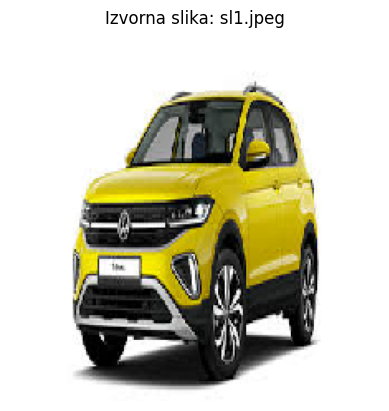

Verjetnosti kategorij: [0.11826857 0.97903603 0.9836924  0.15482256]
Napovedana kategorija: Motociklist

------------------------------------
Slika: sl7.jpeg


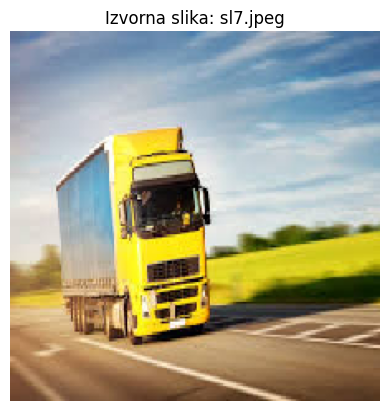

Verjetnosti kategorij: [0.9428518  0.13215178 0.9976125  0.19525373]
Napovedana kategorija: Motociklist

------------------------------------
Slika: sl2.jpg


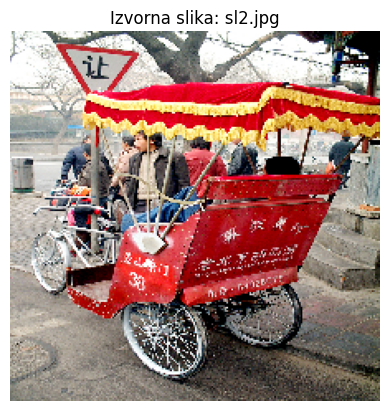

Verjetnosti kategorij: [0.37018052 0.32852757 0.87947214 0.9853996 ]
Napovedana kategorija: Tovornjak

------------------------------------
Slika: sl4.jpeg


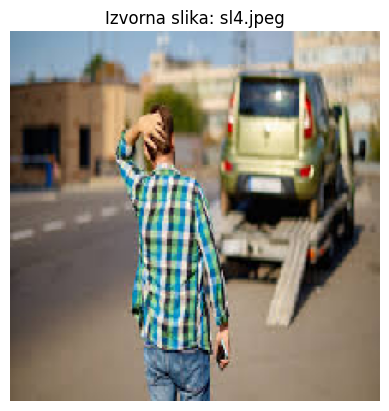

Verjetnosti kategorij: [0.4970928  0.4247322  0.88585037 0.9642601 ]
Napovedana kategorija: Tovornjak

------------------------------------
Slika: sl5.jpeg


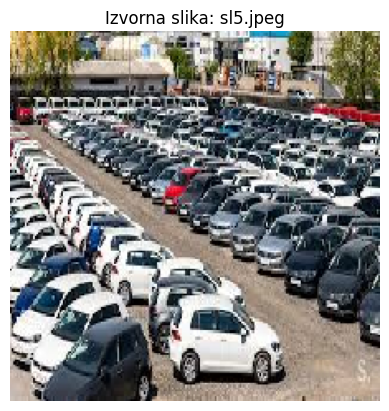

Verjetnosti kategorij: [0.9724341 0.6040698 0.9077587 0.6641971]
Napovedana kategorija: Avtobus

------------------------------------
Slika: sl3.jpeg


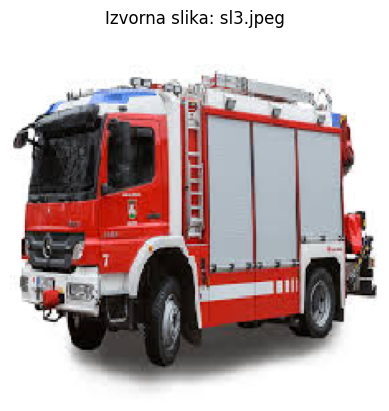

Verjetnosti kategorij: [0.998188   0.13374324 0.9984688  0.08753771]
Napovedana kategorija: Motociklist

------------------------------------
Slika: sl8.jpeg


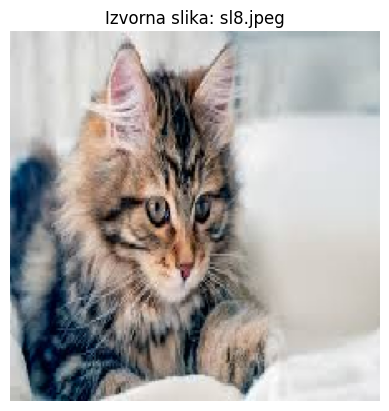

Verjetnosti kategorij: [0.23802681 0.10048443 0.97053444 0.99261075]
Napovedana kategorija: Tovornjak


In [12]:

#from tensorflow.keras.preprocessing import image

# imena kategorij – prilagodi, če so pri tebi drugačna
class_names = ['Avtobus', 'Avtomobil', 'Motociklist', 'Tovornjak']

# mapa, kjer so testne slike
folder = "moja_vozila"

# seznam vseh slik v mapi
files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for fname in files:
    print("\n------------------------------------")
    print("Slika:", fname)

    # naložimo sliko
    img_path = os.path.join(folder, fname)
    img = image.load_img(img_path, target_size=(224,224))

    # izris slike
    plt.imshow(img)
    plt.title(f"Izvorna slika: {fname}")
    plt.axis('off')
    plt.show()

    # pretvorimo v numerično obliko
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # napoved modela
    prediction = model_trafic.predict(img_array, verbose=0)

    # izpis verjetnosti
    print("Verjetnosti kategorij:", prediction[0])

    # najverjetnejša kategorija
    predicted_class = class_names[np.argmax(prediction)]
    print("Napovedana kategorija:", predicted_class)



Kot vidimo, model ne deluje povsem optimalno. Že to, da smo slike prilagajali na velikost 224 × 224, povzroči popačenje in posledično napačno kategorizacijo. Tudi manjše spremembe, kot so drugačna osvetlitev, prisotnost drugih objektov in podobno, lahko zmedejo model. Zato je najbolje, če model dodatno "natreniramo" na slikah, ki so čim bližje naši situaciji – na primer na slikah, pridobljenih z lokalno kamero, ki snema promet.

## 2.5 Sranjevanje in nalaganje modela

Ko enkrat model natreniramo, ga lahko shranimo v datoteko tipa .keras. Če pa želimo model uvoziti in uporabiti, na primer za mobilno aplikacijo, ga lahko izvozimo v TensorFlow obliko. Ukaz model.export bo ustvaril mapo, v katero bodo shranjene različne datoteke, ki predstavljajo model.

Model nato naložimo na podoben način, le da je za njegovo nalaganje potrebna posebna Python knjižnica.


In [17]:
model_trafic.save("moj_model.keras")
model_trafic.export("moj_model_tf")  # Ustvari mapo SavedModel

from tensorflow.keras.models import load_model
model2 = load_model("moj_model.keras") 


INFO:tensorflow:Assets written to: moj_model_tf/assets


INFO:tensorflow:Assets written to: moj_model_tf/assets


Saved artifact at 'moj_model_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133566862419824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862424752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862375072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862709456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862713152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862709280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862715968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862712272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862720016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862714736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133566862718432: T